## Load DATA

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %matplotlib widget
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

Importing plotly failed. Interactive plots will not work.


In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [5]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best, y_pred

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [5]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [6]:
type_target = 'hospitalisations'
assert type_target in ['hospitalisations', 'arrivees_urgences']

In [7]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [8]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures(include_emmergency_arrivals=True, include_nb_hospit=True),
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [9]:
# Select the target columns to be predicted
if type_target == 'hospitalisations':
    target_column = ['nb_vers_hospit']
else:
    target_column = ['nb_emmergencies']
# target_column = ['nb_vers_hospit']
# target_column = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [10]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [11]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [12]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x144b75750>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x144b742b0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x144b743d0>)],
                  verbose=True)

In [13]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [14]:
features_config_get = {}

In [15]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_column,
    'targets_shift': 0,
    'targets_rolling_window': 0,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [16]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-27 18:02:01,599: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-27 18:02:01,605: INFO: Initialisation des features
root 2024-11-27 18:02:01,606: INFO: Fetching dataset
hospitalfeatures 2024-11-27 18:02:01,915: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:02,151: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:02,390: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:02,631: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:02,892: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:03,151: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:03,385: INFO: populationfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:03,621: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-27 18:02:04,000: INFO:

Dropped 90 constant columns from both sets: {'NO2_FR26094', 'PM10_FR26094', 'PM10_FR26010', 'NO2_FR26010', 'PM25_FR26094', 'trend_épilepsie'}
X shape: (1167, 1800), y shape: (1167, 1)
[ColumnTransformer] .... (1 of 5) Processing pipeline-1, total=   0.1s
[ColumnTransformer] .... (2 of 5) Processing pipeline-2, total=   0.1s
[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.1s


root 2024-11-27 18:02:07,746: INFO: 63 features not encoded (same unit as target)


[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.1s


In [17]:
df = arsTabularDataset.data
df

,Y40T59%%J-7,trend_accident de voiture%%mean_31J,trend_stress%%J-3,trend_vaccin%%J-5,trend_urgences%%mean_365J,meteo_snow,trend_pneumonie%%mean_14J,Y10T14%%J-2,trend_crise de panique%%J-5,Y35T39%%std_365J,...,Y70T74%%std_14J,Y80T84%%J-5,trend_éruption cutanée%%mean_31J,trend_allergie%%J-5,inc_grippe%%mean_31J,trend_trouble bipolaire%%std_7J,inc_grippe%%J-3,trend_schizophrénie%%J-4,trend_crise de panique%%std_7J,trend_vertiges%%std_31J
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,0.0000,0.0
2019-01-02,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,0.0000,0.0
2019-01-03,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
2019-01-04,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
2019-01-05,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,132121.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.252097,...,7.508237,15368.0,0.000000,0.0,3475.870968,0.0,3419.0,0.0,0.0000,0.0
2023-12-26,132119.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.294820,...,7.590118,15369.0,0.000000,0.0,3410.516129,0.0,3419.0,0.0,0.0000,0.0
2023-12-27,132116.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.327045,...,7.590118,15370.0,0.000000,0.0,3345.161290,0.0,3419.0,0.0,0.0000,0.0


In [18]:
assert type_target in ['hospitalisations', 'arrivees_urgences']
if type_target == 'hospitalisations':
    # df.rename({target_column[0]: 'target'}, axis=1, inplace=True)
    # df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    df.rename({'nb_emmergencies': 'arrivees_urgences'}, axis=1, inplace=True)
    # df = df[['arrivees_urgences', 'hospitalisations']]
else:
    pass
    # df.rename({target_column[0]: 'target'}, axis=1, inplace=True)
    # df['target'] = df[type_target].copy()
    # df = df[['arrivees_urgences']]
df.rename({arsTabularDataset.targets_names[0]: 'target'}, axis=1, inplace=True)

In [19]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3


In [20]:
# df.rename({type_target: 'target'}, axis=1, inplace=True)
# df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
# df['target'] = df['mean'].shift(-2*horizon+1)
# df.drop('mean', axis=1, inplace=True)

# df.dropna(inplace=True)
# df.shape

<Axes: xlabel='date'>

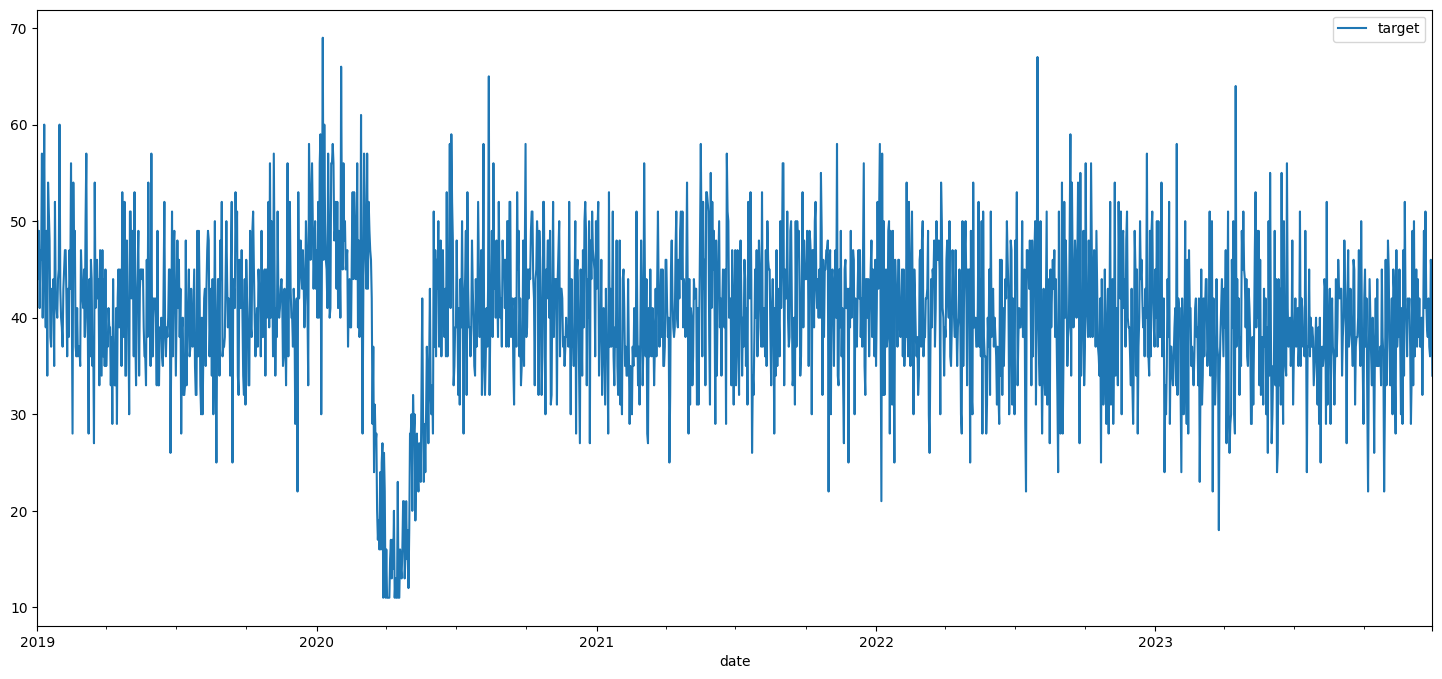

In [21]:
df.plot(y='target')

In [22]:
df

,Y40T59%%J-7,trend_accident de voiture%%mean_31J,trend_stress%%J-3,trend_vaccin%%J-5,trend_urgences%%mean_365J,meteo_snow,trend_pneumonie%%mean_14J,Y10T14%%J-2,trend_crise de panique%%J-5,Y35T39%%std_365J,...,Y70T74%%std_14J,Y80T84%%J-5,trend_éruption cutanée%%mean_31J,trend_allergie%%J-5,inc_grippe%%mean_31J,trend_trouble bipolaire%%std_7J,inc_grippe%%J-3,trend_schizophrénie%%J-4,trend_crise de panique%%std_7J,trend_vertiges%%std_31J
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,0.0000,0.0
2019-01-02,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,0.0000,0.0
2019-01-03,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
2019-01-04,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
2019-01-05,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,20.916501,15266.0,2.709677,0.0,1955.903226,0.0,125.0,0.0,28.7253,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,132121.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.252097,...,7.508237,15368.0,0.000000,0.0,3475.870968,0.0,3419.0,0.0,0.0000,0.0
2023-12-26,132119.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.294820,...,7.590118,15369.0,0.000000,0.0,3410.516129,0.0,3419.0,0.0,0.0000,0.0
2023-12-27,132116.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.327045,...,7.590118,15370.0,0.000000,0.0,3345.161290,0.0,3419.0,0.0,0.0000,0.0


In [23]:
df['target']

date
2019-01-01    50.0
2019-01-02    44.0
2019-01-03    49.0
2019-01-04    41.0
2019-01-05    47.0
              ... 
2023-12-25    37.0
2023-12-26    36.0
2023-12-27    46.0
2023-12-28    44.0
2023-12-29    34.0
Name: target, Length: 1824, dtype: float64

In [24]:
print(f"Moyenne : {df['target'].mean():.2f}, Ecart-type : {df['target'].std():.2f}")
print(f"Baseline : {mean_absolute_error(df['target'], [df['target'].mean()]*len(df)):.2f}")

Moyenne : 40.19, Ecart-type : 8.10
Baseline : 6.21


In [25]:
for k in range(1, 15):
    df[f'target_history-{k}'] = df['target'].shift(k)

In [26]:
shifted = df["target"].shift(2*horizon-1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'target_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)

# shifted = df[type_target].shift(1)
# for ma in [2, 3, 7, 15, 30]:    
#     window = shifted.rolling(window=ma)
#     df[f'{type_target}_ma_{ma}'] = window.mean()
#     df.bfill(inplace=True)


In [27]:
# On sauvegarde notre dataframe
col_rem = ['date', 'location']
df.drop(col_rem, axis=1, inplace=True)
df0 = df.copy()

In [28]:
df0

,Y40T59%%J-7,trend_accident de voiture%%mean_31J,trend_stress%%J-3,trend_vaccin%%J-5,trend_urgences%%mean_365J,meteo_snow,trend_pneumonie%%mean_14J,Y10T14%%J-2,trend_crise de panique%%J-5,Y35T39%%std_365J,...,target_history-10,target_history-11,target_history-12,target_history-13,target_history-14,target_ma_2,target_ma_3,target_ma_7,target_ma_15,target_ma_30
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,50.0,50.0,50.0,50.0,50.0,47.0,47.666667,47.714286,46.733333,45.433333
2019-01-02,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,50.0,50.0,50.0,50.0,50.0,47.0,47.666667,47.714286,46.733333,45.433333
2019-01-03,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30609.0,0.0,72.537641,...,50.0,50.0,50.0,50.0,50.0,47.0,47.666667,47.714286,46.733333,45.433333
2019-01-04,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,50.0,50.0,50.0,50.0,50.0,47.0,47.666667,47.714286,46.733333,45.433333
2019-01-05,135882.0,3.225806,0.0,0.0,0.397260,0.0,0.0,30608.0,0.0,72.537641,...,50.0,50.0,50.0,50.0,50.0,47.0,47.666667,47.714286,46.733333,45.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,132121.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.252097,...,40.0,37.0,37.0,42.0,38.0,40.0,41.333333,40.285714,39.733333,39.466667
2023-12-26,132119.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.294820,...,32.0,40.0,37.0,37.0,42.0,39.5,39.000000,40.428571,39.533333,39.466667
2023-12-27,132116.0,1.612903,0.0,0.0,1.317808,0.0,0.0,30204.0,0.0,123.327045,...,39.0,32.0,40.0,37.0,37.0,37.0,38.666667,40.000000,39.200000,39.400000


In [29]:

def rank_features(df):
    params = {'eta': 0.05, 
            'objective': 'reg:absoluteerror', 
            'eval_metric': ['rmse', 'mae'],
            'subsample': 0.7, 
            'colsample_bytree': 1,
            'nthread': -1}

    new_score, bst, y_pred = teste(df, params)

    importance_gain = bst.get_score(importance_type='gain')
    importance_cover = bst.get_score(importance_type='cover')
    importance_weight = bst.get_score(importance_type='weight')
    df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
    df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
    df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])
    df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    df.fillna(0, inplace=True)
    df['gain_norm'] = df['gain'] / df['gain'].sum()
    df['cover_norm'] = df['cover'] / df['cover'].sum()
    df['weight_norm'] = df['weight'] / df['weight'].sum()
    w_gain = 0.5
    w_cover = 0.3
    w_weight = 0.2
    df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)
    df.sort_values(by='importance', ascending=False, inplace=True)
    df['rank'] = df['importance'].rank(ascending=False)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'feature'}, inplace=True)
    print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']].head(20))
    return df



In [30]:

def select_features(df, cols_histo = [], nb_features=50):
    cols = []
    features = rank_features(df)
    cols = features['feature'].tolist()[:nb_features]
    cols_exo = [item for item in cols if (target_column[0] not in item) and ('target' not in item)]
    if cols_histo == []:
        cols_histo = [item for item in cols if (target_column[0] in item) or ('target' in item)][:5]
    
    # cols_histo = []
    cols = cols_histo + cols_exo

    cols.append('target')
    return cols

In [31]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

In [32]:


def test_prediction(df, cols, horizon=7):
    regs = {'trend': {}, 'resid': {}, 'seasonal': {}}
    # cols = ['arrivees_urgences', 'air_PM10_FR26014_mean', 'trend_grippe_std', 'trend_maladie_mean', 'holidays', 
            # 'meteo_night_CHU DIJON_0_temp_mean', 'target_ma_7']

    for k in range(1, 2*horizon+1):
        print(f"horizon: {k}")
        dg = df[cols].copy()
        dg['target'] = dg['target'].shift(-k)
        dg.dropna(inplace=True)
        regs['seasonal'][k] = seasonal_decompose(dg['target'], model='additive', period=7).seasonal
        dg['target'] = seasonal_decompose(dg['target'], model='additive', period=7).trend
        dg.dropna(inplace=True)
        train_val_test = dg.loc[dg.index.year < 2023]
        d_final = dg.loc[dg.index.year == 2023]
        X_final = d_final.drop('target', axis=1)
        y_final = d_final['target']
        X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                            train_val_test['target'], 
                                                            test_size=0.2, shuffle=False)

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        evals = [(dtrain, 'train'), (dvalid, 'eval')]
        regs['trend'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=False)
        y_pred = regs['trend'][k].predict(xgb.DMatrix(X_final))
        dg[f'target'] = seasonal_decompose(dg['target'], model='additive', period=7).resid
        dg.dropna(inplace=True)
        train_val_test = dg.loc[dg.index.year < 2023]
        d_final = dg.loc[dg.index.year == 2023]
        X_final = d_final.drop('target', axis=1)
        y_final = d_final['target']
        X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                            train_val_test['target'], 
                                                            test_size=0.2, shuffle=False)

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        evals = [(dtrain, 'train'), (dvalid, 'eval')]
        regs['resid'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=False)
        y_pred = regs['resid'][k].predict(xgb.DMatrix(X_final))
        df[f'{type_target}+{k}'] = dg.target.copy()

    dg = df.copy()
    for k in range(1, 2*horizon+1):
        print(f"horizon: {k}")
        X_final[f'{type_target}+{k}'] = regs['trend'][k].predict(xgb.DMatrix(X_final[regs['trend'][k].feature_names]))
        X_final[f'{type_target}+{k}'] += regs['resid'][k].predict(xgb.DMatrix(X_final[regs['resid'][k].feature_names]))
        X_final[f'{type_target}+{k}'] += regs['seasonal'][k]


    X_final['prediction'] = X_final.apply(lambda x: statistics.mean([x[f'{type_target}+{k}'] for k in range(horizon, 2*horizon)]), axis=1)

    X_final['target'] = df.loc[df.index.year == 2023]['target']
    # X_final['target'] = X_final['target'].shift(-(horizon//2)).rolling(window=(horizon//2), min_periods=1).mean()
    X_final.dropna(inplace=True)
    X_final.plot(y=['target', 'prediction'], title=f'{arsTabularDataset.targets_names[0]}, MAE: {mean_absolute_error(X_final["target"], X_final["prediction"]):.2f}')
    return X_final


TREND
Amélioration avec max_depth=5: 100000.0000 -> 21.4082


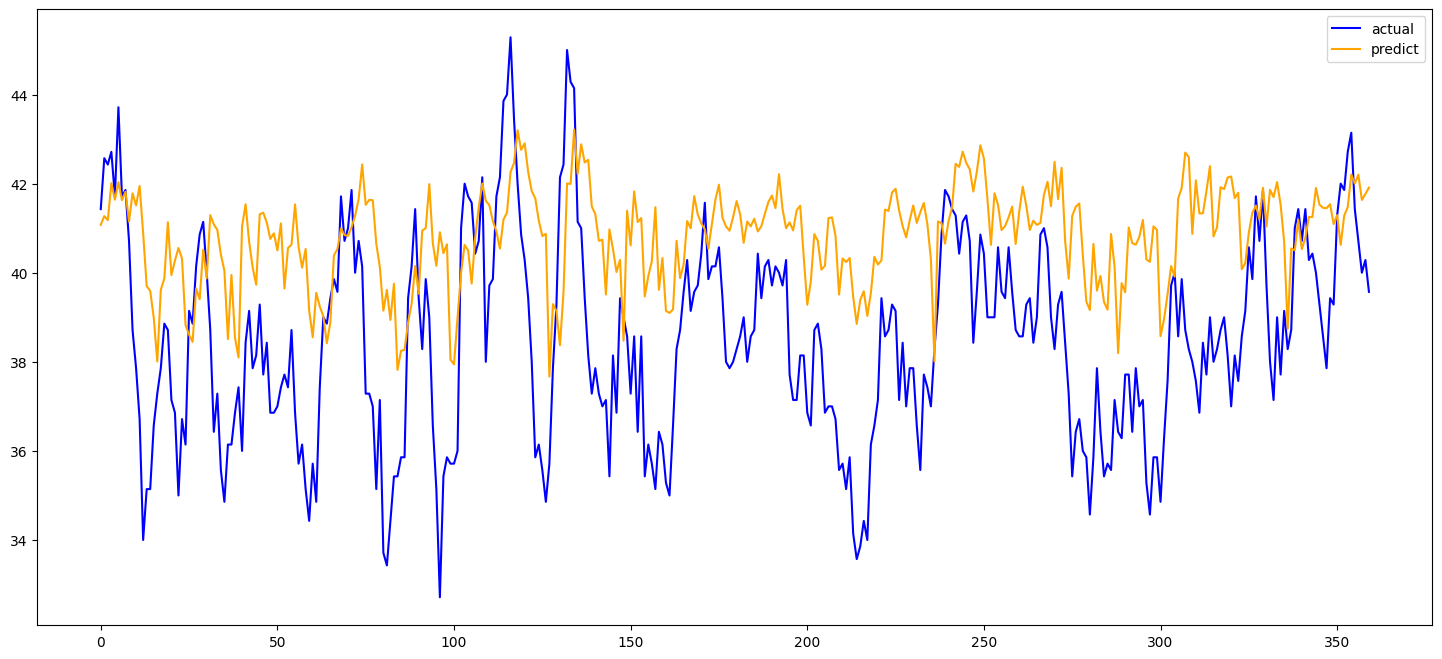

6.39%,1%
15.00%,2%
20.56%,3%
28.61%,4%
38.06%,5%
44.44%,6%
52.78%,7%
61.67%,8%
69.17%,9%
76.11%,10%
81.94%,11%
   - MAE : 2.74 (2.63 sur 2023)
   - MSE : 21.41 (9.43 sur 2023)
                                              feature       gain       cover  \
0   target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%...  79.932579  656.857117   
1                                 nb_vers_hospit%%J-2  34.232296  481.559998   
2           target_nb_vers_hospit_CHU Dijon%%J+1%%J-2  25.453562  394.692322   
3           target_nb_vers_hospit_CHU Dijon%%J+1%%J-1  33.895424  503.200012   
4                            nb_emmergencies%%mean_7J  59.604610  822.000000   
5   target_nb_vers_hospit_CHU Dijon%%J+1%%mean_14J...  61.420456  593.166687   
6                              trend_asthme%%std_365J  44.870434  724.599976   
7                                   arrivees_urgences  34.432899  582.571411   
8                                         Y20T39%%J-6  38.881100  759.000000   
9                       

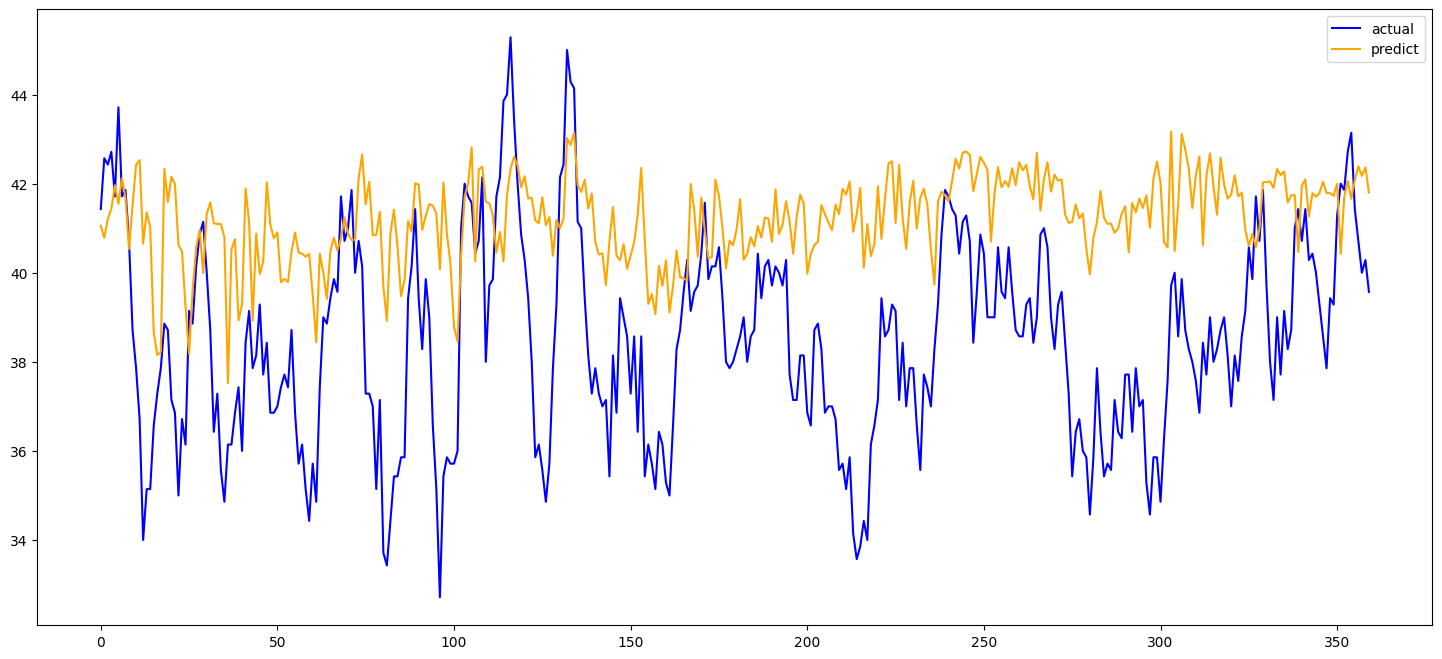

5.28%,1%
11.67%,2%
19.44%,3%
27.50%,4%
34.17%,5%
39.44%,6%
46.11%,7%
52.22%,8%
60.83%,9%
69.17%,10%
76.94%,11%
   - MAE : 2.86 (2.97 sur 2023)
   - MSE : 22.96 (12.00 sur 2023)


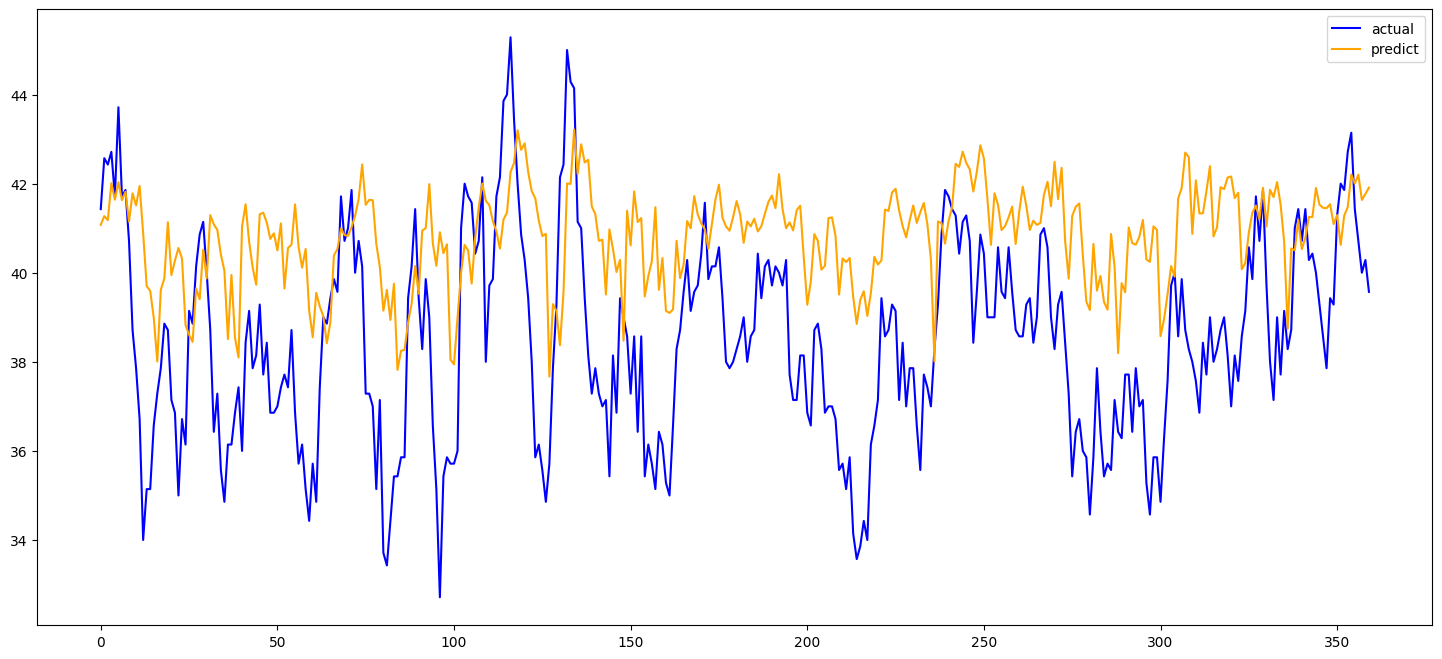

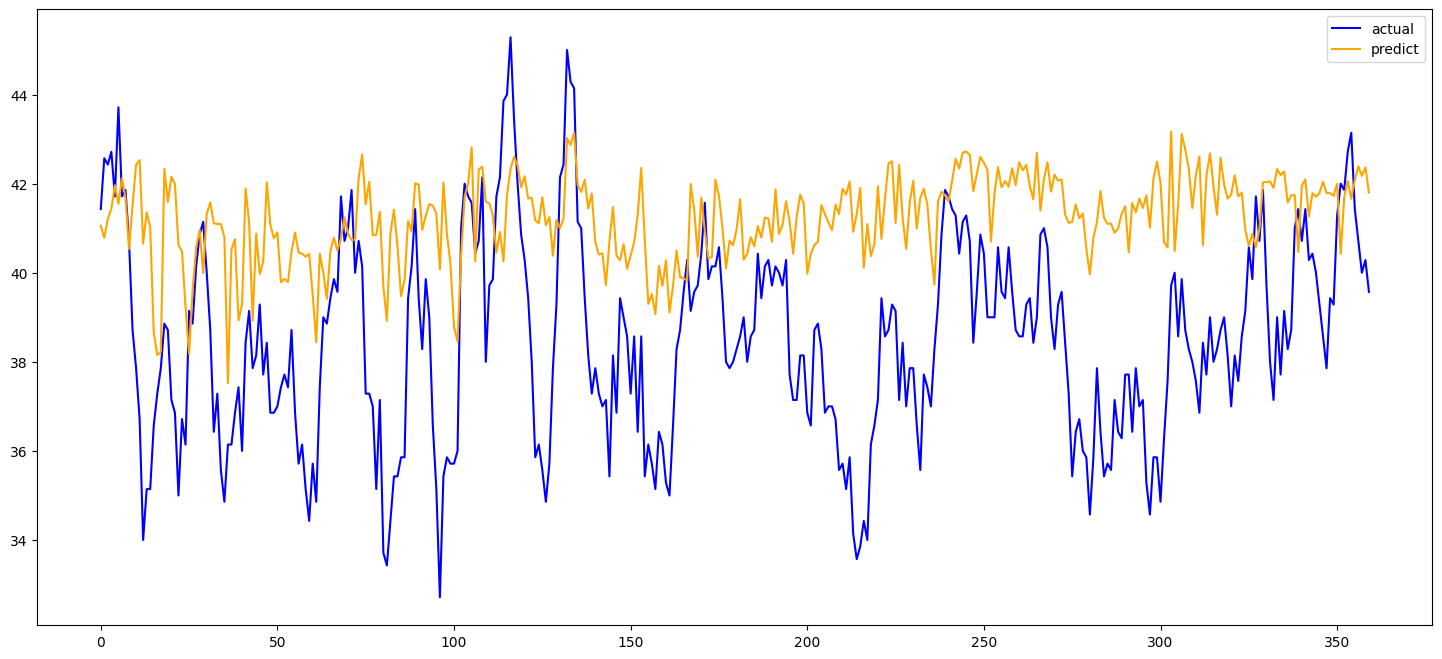

In [ ]:
print('TREND')
cols_histo = [
        # 'nb_vers_hospit%%mean_7J',
        'nb_vers_hospit%%J-4',
        # 'nb_vers_hospit%%J-3',
        # 'nb_vers_hospit%%J-2',
        'nb_vers_hospit%%J-1',
        'target_history-14',
        'target_ma_2',
        # 'target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%%J-1',
        'target_nb_vers_hospit_CHU Dijon%%J+1%%J-7',
        'nb_vers_hospit%%mean_365J',
        ]
df_trend = df.copy()
df_trend['target'] = seasonal_decompose(df_trend['target'], model='additive', period=7).trend
df_trend.dropna(inplace=True)
cols = select_features(df_trend, cols_histo=cols_histo, nb_features=50)
new_score, bst, y_pred_trend = teste(df_trend[cols], params)
# X_final_trend = test_prediction(df_trend[cols], cols, horizon=7)['prediction']

RESID
Amélioration avec max_depth=5: 100000.0000 -> 33.7953


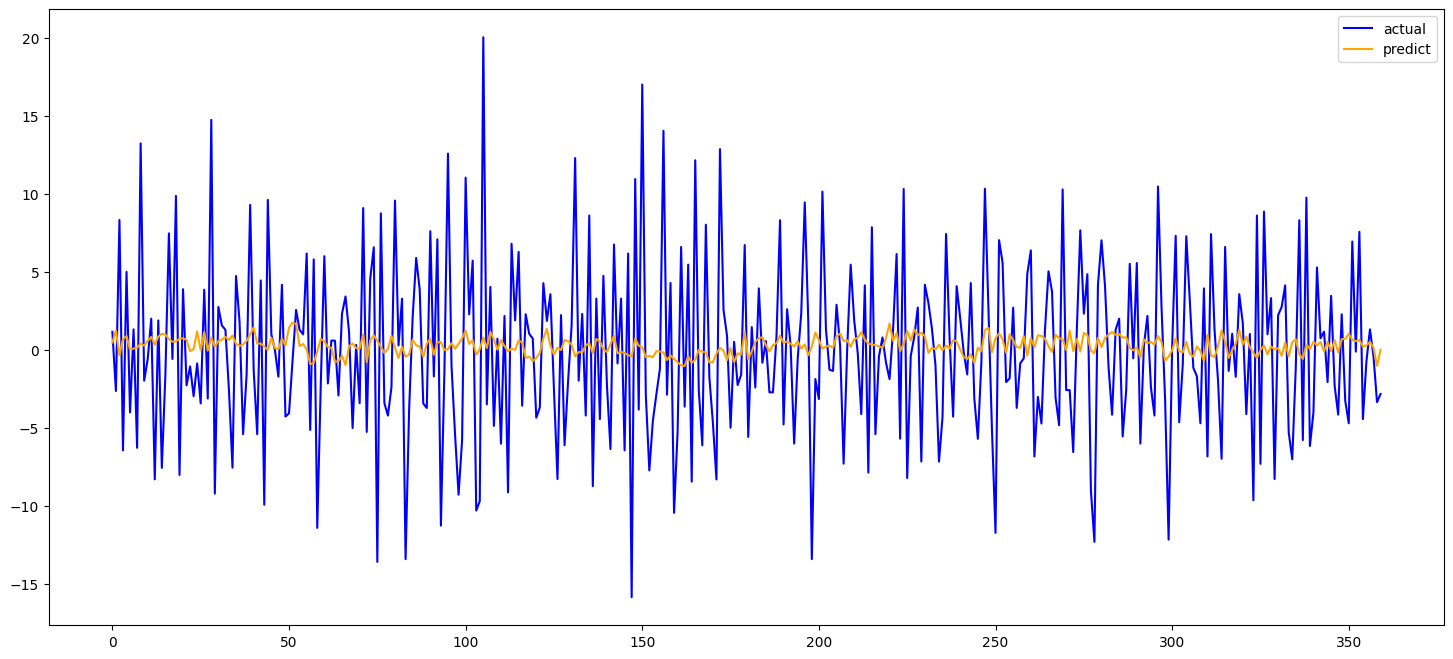

0.00%,1%
0.00%,2%
0.00%,3%
0.00%,4%
0.00%,5%
0.00%,6%
0.00%,7%
0.00%,8%
0.00%,9%
0.00%,10%
0.00%,11%
   - MAE : 4.65 (4.48 sur 2023)
   - MSE : 33.80 (31.54 sur 2023)
                                              feature       gain       cover  \
0   target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%...  13.637368  814.666687   
1                                   PM10_FR26014%%J-6  13.757332  811.000000   
2                                     meteo_pres%%J-2  13.493406  815.000000   
3           target_nb_vers_hospit_CHU Dijon%%J+1%%J-1  11.666715  483.142853   
4                                     O3_FR26005%%J-5  12.387583  813.000000   
5                                   target_history-13  12.366518  803.000000   
6                                nb_emmergencies%%J-5  10.039446  841.000000   
7                           trend_médicament%%mean_7J  10.360725  775.000000   
8                                trend_pharmacie%%J-4  14.003057  580.500000   
9                                

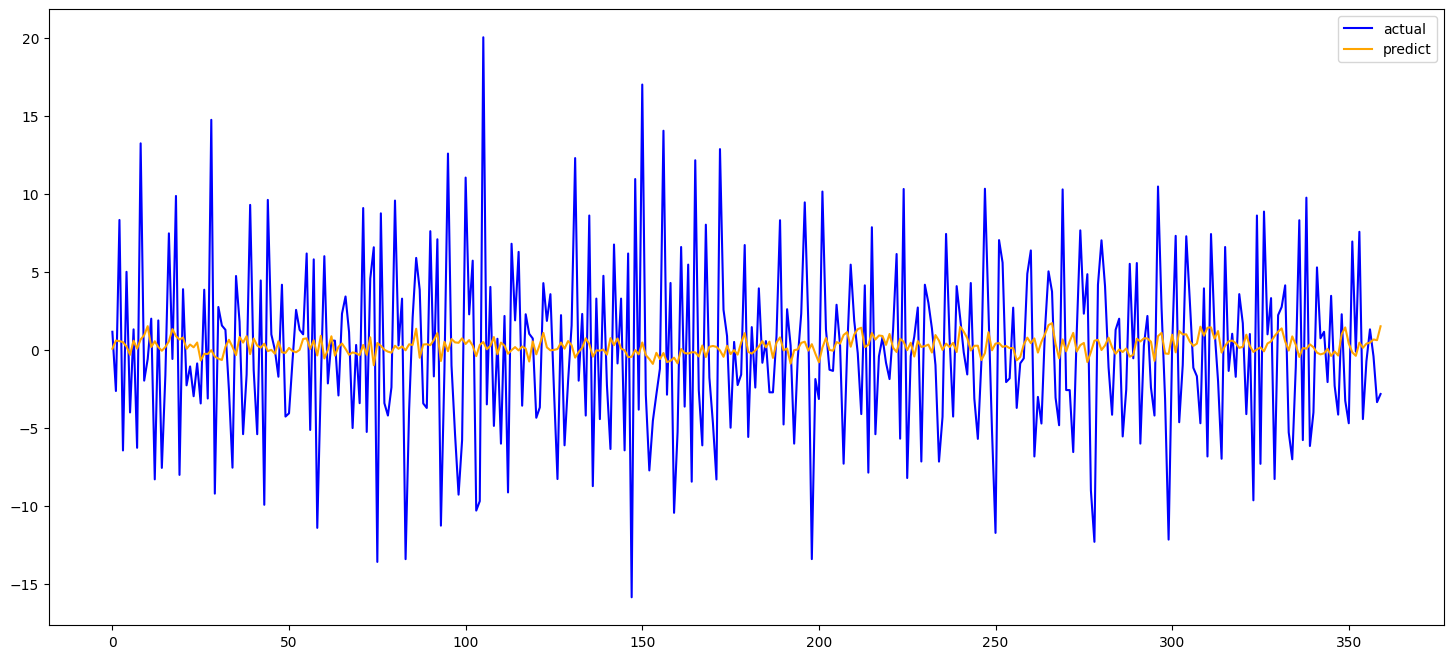

0.00%,1%
0.00%,2%
0.00%,3%
0.00%,4%
0.00%,5%
0.00%,6%
0.00%,7%
0.00%,8%
0.00%,9%
0.00%,10%
0.00%,11%
   - MAE : 4.66 (4.52 sur 2023)
   - MSE : 33.92 (31.97 sur 2023)


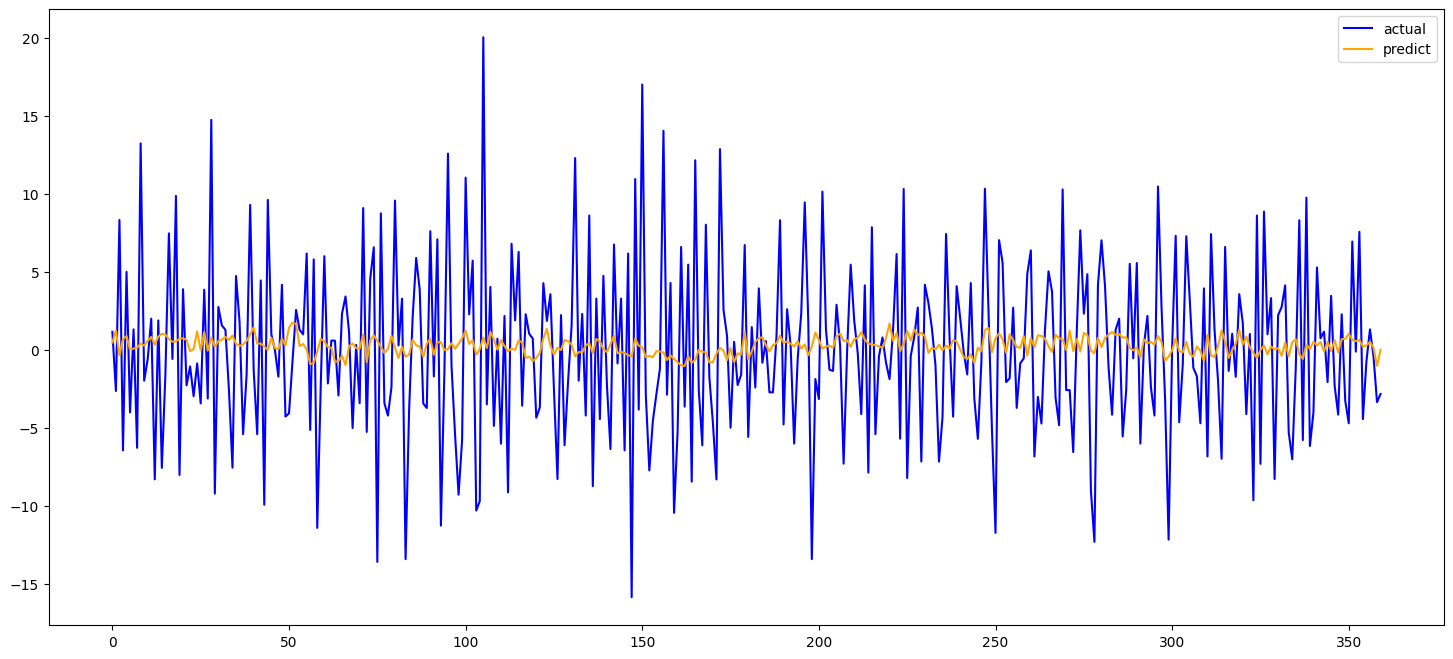

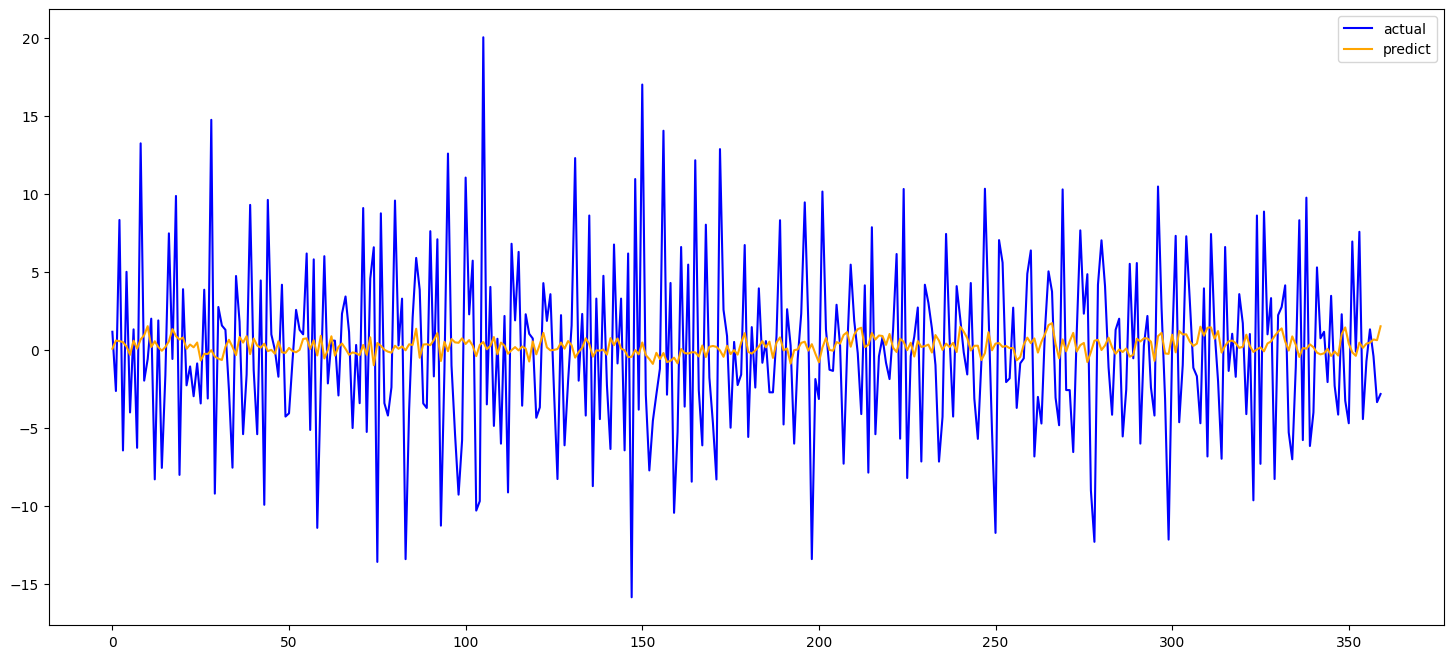

In [34]:
print('RESID')
df_resid = df.copy()
df_resid['target'] = seasonal_decompose(df_resid['target'], model='additive', period=7).resid
df_resid.dropna(inplace=True)
cols = select_features(df_resid)
new_score, bst, y_pred_resid = teste(df_resid[cols], params)
# y_pred_resid = test_prediction(df_resid[cols], cols, horizon=7)['prediction']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


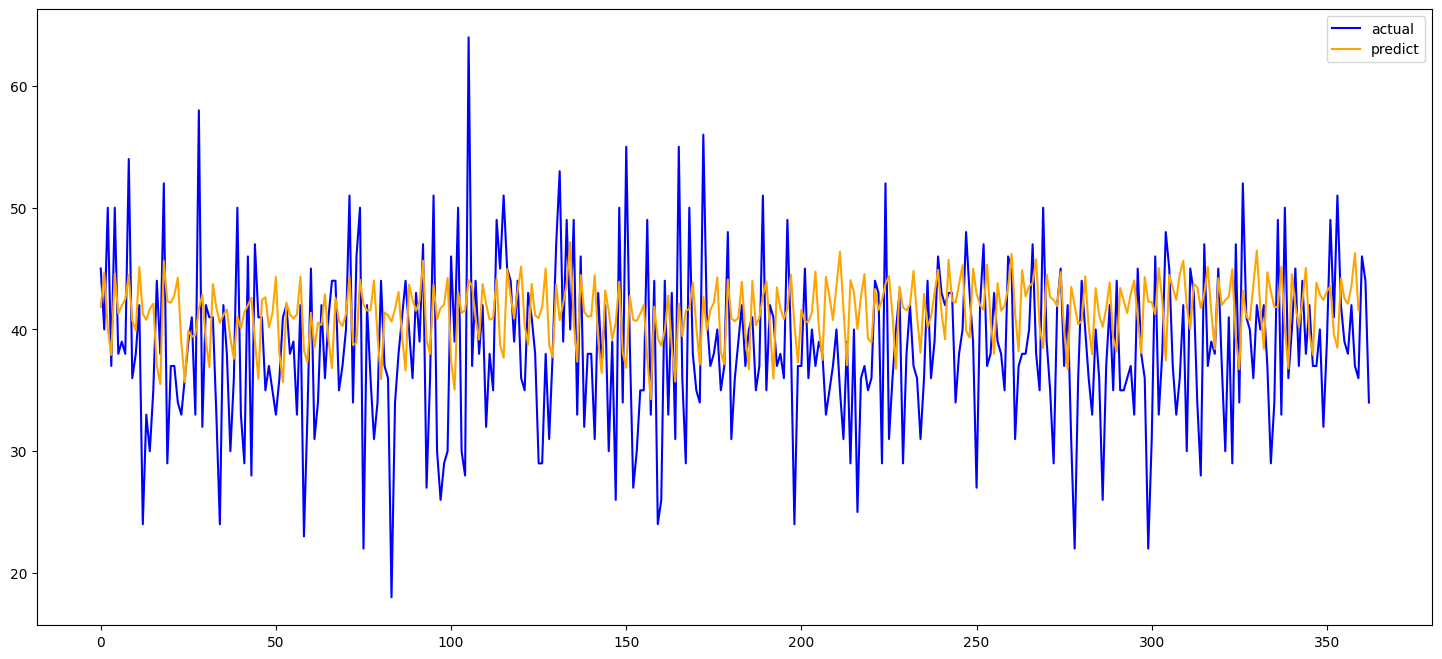

MAE : 5.56


In [35]:




season = seasonal_decompose(df['target'], model='additive', period=7).seasonal

pred = y_pred_trend + y_pred_resid + season[-360:]
y_final = df.loc[df.index.year == 2023]['target']
y_final.dropna(inplace=True)
pred.dropna(inplace=True)
# y_final = y_final[-330:]
# pred = pred[-330:]
plt.figure()
plt.plot(range(len(y_final)), y_final, label='actual', color='blue')
plt.plot(range(len(pred)), pred, label='predict', color='orange')
plt.legend()
plt.show()
print(f"MAE : {mean_absolute_error(y_final[-360:], pred[-360:]):.2f}")

MAE : 3.24


<Axes: title={'center': 'target_nb_vers_hospit_CHU Dijon%%J+1, MAE: 3.24, (M7+J7)'}, xlabel='date'>

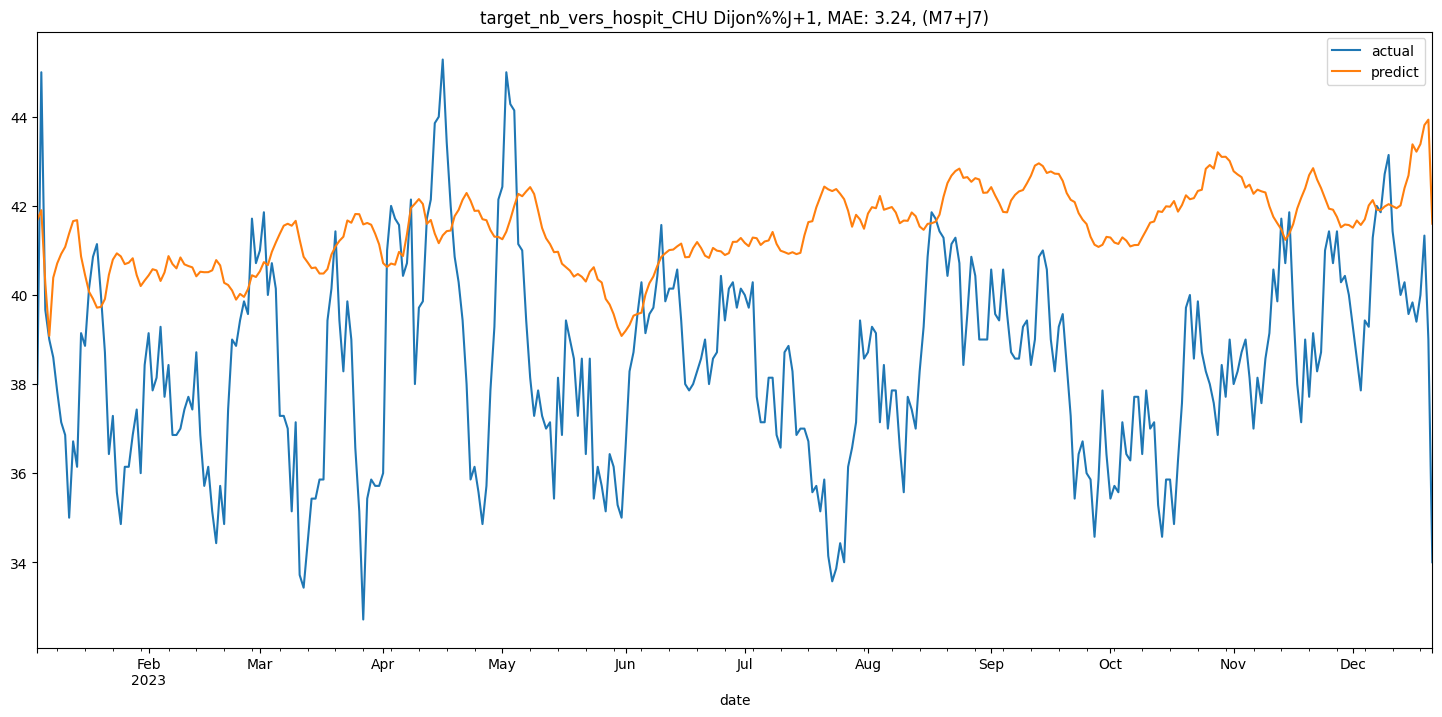

In [36]:
df_results = pd.DataFrame({'actual': y_final[-360:], 'predict': pred[-360:]})
df_results['actual'] = df_results['actual'].shift(-14).rolling(window=7, min_periods=1).mean()
df_results['predict'] = df_results['predict'].shift(-14).rolling(window=7, min_periods=1).mean()
df_results.dropna(inplace=True)
mae = mean_absolute_error(df_results['actual'], df_results['predict'])
print(f"MAE : {mae:.2f}")
df_results.plot(title=f'{arsTabularDataset.targets_names[0]}, MAE: {mae:.2f}, (M7+J7)')


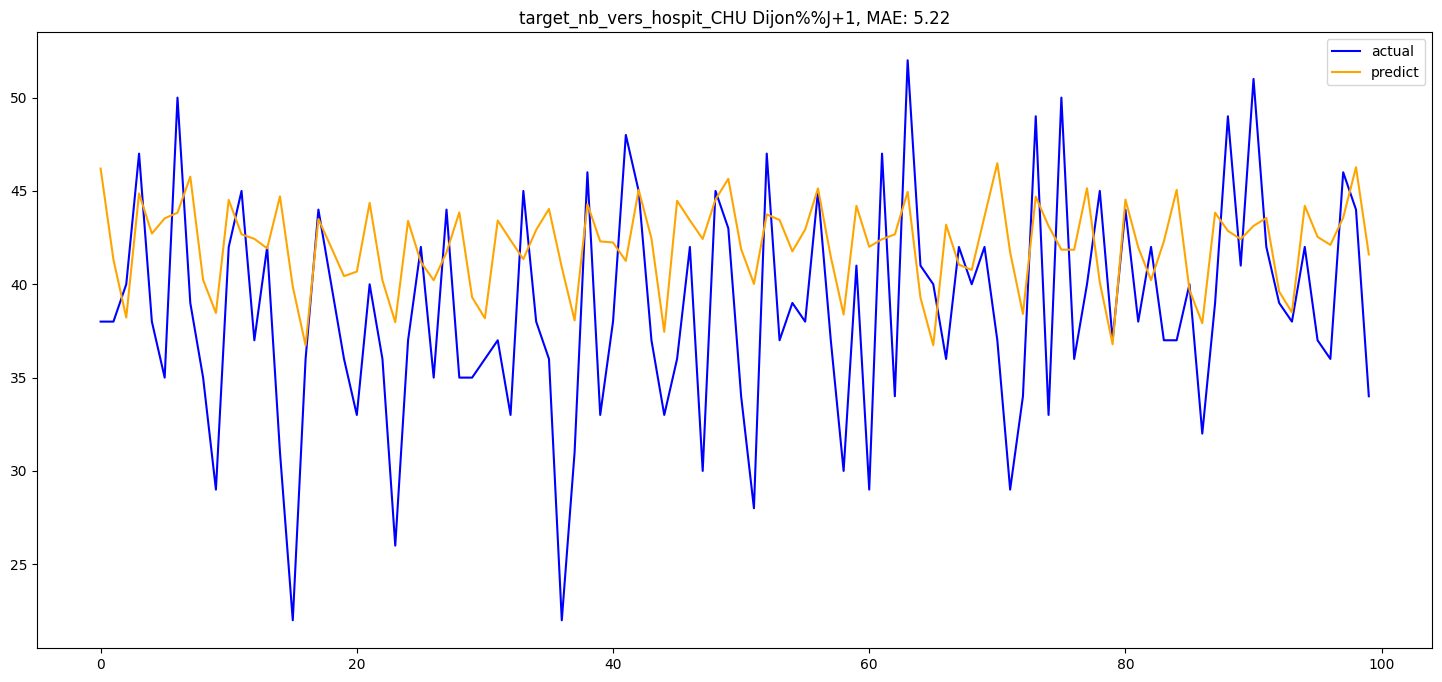

In [37]:
cut = 100
plt.plot(range(len(y_final[-cut:])), y_final[-cut:], label='actual', color='blue')
plt.plot(range(len(pred[-cut:])), pred[-cut:], label='predict', color='orange')
plt.title(f'{arsTabularDataset.targets_names[0]}, MAE: {mean_absolute_error(y_final[-cut:], pred[-cut:]):.2f}')
plt.legend()